In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler
import gseapy as gp

# scDRS tools
import scdrs

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_top1000_zscore.74_traits.rv1.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_hep.rv1'

# Data set info
DS_LIST = ['facs', 'droplet', 'aizarani', 'halpern', 'richter', 'rao']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}
DIC_INFO['aizarani'] = {'species': 'hsapiens', 'dname': 'Aizarani'}
DIC_INFO['halpern'] = {'species': 'mmusculus', 'dname': 'Halpern & Shenhav'}
DIC_INFO['richter'] = {'species': 'mmusculus', 'dname': 'Richter & Deligiannis'}
DIC_INFO['rao'] = {'species': 'mmusculus', 'dname': 'Taychameekiatchai'}

# Set score files
# Include n_genes as cov only for atlas. Include individual ID as covariates when available
DIC_SCORE_PATH = {
    'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore',
    'facs.hm': DATA_PATH+'/score_file/score.tms_facs_with_cov.hep_metabolic',
    'droplet': DATA_PATH+'/score_file/score.tms_droplet_with_cov.magma_10kb_top1000_zscore',
    'droplet.hm': DATA_PATH+'/score_file/score.tms_droplet_with_cov.hep_metabolic',
    'aizarani': DATA_PATH+'/score_file/score.liver_atlas.magma_10kb_top1000_zscore', # no cov
    'aizarani.hm': DATA_PATH+'/score_file/score.liver_atlas.hep_metabolic',
    'halpern': DATA_PATH+'/score_file/score.mouse_liver_halpern.magma_10kb_top1000_zscore', # no cov
    'halpern.hm': DATA_PATH+'/score_file/score.mouse_liver_halpern.hep_metabolic',  
    'richter': DATA_PATH+'/score_file/score.richter_with_cov.magma_10kb_top1000_zscore', # ID.Individual
    'richter.hm': DATA_PATH+'/score_file/score.richter_with_cov.hep_metabolic',  
    'rao': DATA_PATH+'/score_file/score.rao_wang_with_cov.magma_10kb_top1000_zscore', # sex
    'rao.hm': DATA_PATH+'/score_file/score.rao_wang_with_cov.hep_metabolic',  
}

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['facs'] = ['UKB_460K.biochemistry_Triglycerides', 
                          'UKB_460K.biochemistry_HDLcholesterol',
                          'UKB_460K.biochemistry_LDLdirect',
                          'UKB_460K.biochemistry_Cholesterol',
                          'UKB_460K.biochemistry_Testosterone_Male',
                          'UKB_460K.biochemistry_AlanineAminotransferase',
                          'UKB_460K.biochemistry_AlkalinePhosphatase',
                          'UKB_460K.biochemistry_SHBG',
                          'UKB_460K.biochemistry_TotalBilirubin',
                          'UKB_460K.body_HEIGHTz']
DIC_TRAIT_LIST['facs.hm'] = ['CV', 'PN', 'hep4n_richter', 'hep2n_richter', 
                             'case_96hPH_vs_prePH', 'case_prePH_vs_96hPH', 
                             'case_vs_ctrl_96hPH', 'ctrl_vs_case_96hPH', 'large_vs_small',
                             'Glycolysis', 'Bile acid production', 'Lipogenesis', 'Xenobiotic metabolism',
                             'Beta-oxidation', 'Cholesterol biosynthesis', 'Protein secretion', 'Gluconeogenesis', 
                             ]
DIC_TRAIT_LIST['droplet'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['droplet.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['aizarani'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['aizarani.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['halpern'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['halpern.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['richter'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['richter.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['rao'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['rao.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()

# Set trait info
DIC_HM_NAME = {'CV': 'pericentral',
               'PN': 'periportal',
               'hep4n_richter': '4n hepatocyte (vs. 2n)',
               'hep2n_richter': '2n hepatocyte (vs. 4n)',
               'case_96hPH_vs_prePH': 'polyploid (PH)',
               'case_prePH_vs_96hPH': 'diploid (PH)',
               'case_vs_ctrl_96hPH': 'polyploid (Cdk1 ko)',
               'ctrl_vs_case_96hPH': 'diploid (Cdk1 ko)',
               'large_vs_small': 'large hepatocyte (vs. small)',
               'Beta-oxidation': 'beta-oxidation (PN)',
               'Cholesterol biosynthesis': 'cholesterol biosynthesis (PN)', 
               'Glycolysis': 'glycolysis (CV)', 
               'Protein secretion': 'protein secretion (PN)',
               'Bile acid production': 'bile acid production (CV)', 
               'Gluconeogenesis': 'gluconeogenesis (PN)', 
               'Lipogenesis': 'lipogenesis (CV)', 
               'Xenobiotic metabolism': 'xenobiotic metabolism (CV)'}

for trait in DIC_HM_NAME:
    DF_TRAIT_INFO.loc[trait, 'Code'] = DIC_HM_NAME[trait]

### Load data 

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['facs'] = scdrs.data_loader.load_tms_ct(DATA_PATH, data_name='facs')
dic_data_raw['droplet'] = scdrs.data_loader.load_tms_ct(DATA_PATH, data_name='droplet')
dic_data_raw['aizarani'] = scdrs.data_loader.load_aizarani(DATA_PATH, opt='raw')
dic_data_raw['halpern'] = scdrs.data_loader.load_halpern(DATA_PATH, opt='raw')
dic_data_raw['richter'] = scdrs.data_loader.load_richter(DATA_PATH, opt='raw')
dic_data_raw['rao'] = scdrs.data_loader.load_rao(DATA_PATH, opt='raw')

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/hep.facs_annot.h5ad')
dic_data_proc['droplet'] = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/hep.droplet.h5ad')
dic_data_proc['aizarani'] = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/hep.aizarani.h5ad')
dic_data_proc['halpern'] = scdrs.data_loader.load_halpern(DATA_PATH, opt='processed')
dic_data_proc['richter'] = scdrs.data_loader.read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/hep.richter.h5ad')
dic_data_proc['rao'] = scdrs.data_loader.read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/hep.rao.h5ad')

# Add percent.mt to facs data and filter out high mt cells 
temp_adata = read_h5ad(DATA_PATH+'/tabula_muris_senis/adata_genecode_counts_for_gatk_with_metadata.h5ad')
mt_list = [x for x in temp_adata.var_names if x.startswith('mt-')]
temp_adata.obs['percent.mt'] = temp_adata[:, mt_list].X.sum(axis=1) / temp_adata.X.sum(axis=1)

df_mt = pd.DataFrame(index=dic_data_proc['facs'].obs['cell'])
temp_df = temp_adata.obs.copy()
temp_df.index = temp_df['cell']
df_mt = df_mt.join(temp_df[['percent.mt']])
dic_data_proc['facs'].obs['percent.mt'] = df_mt['percent.mt'].values
dic_data_proc['facs'] = dic_data_proc['facs'][dic_data_proc['facs'].obs['percent.mt']<0.3,:].copy()

Trying to set attribute `.obs` of view, copying.
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for score in DIC_SCORE_PATH:
    ds = score.replace('.hm','')
    dic_cell_list[score] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[score].index))

# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/score_file/score.mouse_liver_halpern.hep_metabolic/Lipogenesis.score.gz
# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/score_file/score.richter_with_cov.hep_metabolic/Lipogenesis.score.gz
# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/score_file/score.rao_wang_with_cov.hep_metabolic/Lipogenesis.score.gz


In [5]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
# for score in ['aizarani', 'halpern', 'richter']:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.full_score.gz'%trait)
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df = temp_df.loc[set(dic_data_proc[ds].obs_names) & set(temp_df.index)]
            dic_ctrl_score[score][trait] = temp_df.copy()
        else:
            print('# missing: %s'%file_path)
            continue
        dic_ctrl_score[score][trait] = dic_ctrl_score[score][trait].loc[dic_cell_list[score]].copy()

# Loading facs UKB_460K.biochemistry_Triglycerides
# Loading facs UKB_460K.biochemistry_HDLcholesterol
# Loading facs UKB_460K.biochemistry_LDLdirect
# Loading facs UKB_460K.biochemistry_Cholesterol
# Loading facs UKB_460K.biochemistry_Testosterone_Male
# Loading facs UKB_460K.biochemistry_AlanineAminotransferase
# Loading facs UKB_460K.biochemistry_AlkalinePhosphatase
# Loading facs UKB_460K.biochemistry_SHBG
# Loading facs UKB_460K.biochemistry_TotalBilirubin
# Loading facs UKB_460K.body_HEIGHTz
# Loading facs.hm CV
# Loading facs.hm PN
# Loading facs.hm hep4n_richter
# Loading facs.hm hep2n_richter
# Loading facs.hm case_96hPH_vs_prePH
# Loading facs.hm case_prePH_vs_96hPH
# Loading facs.hm case_vs_ctrl_96hPH
# Loading facs.hm ctrl_vs_case_96hPH
# Loading facs.hm large_vs_small
# Loading facs.hm Glycolysis
# Loading facs.hm Bile acid production
# Loading facs.hm Lipogenesis
# Loading facs.hm Xenobiotic metabolism
# Loading facs.hm Beta-oxidation
# Loading facs.hm Cholesterol biosynt

### UMAP for all hepatocytes

n_cell=1102


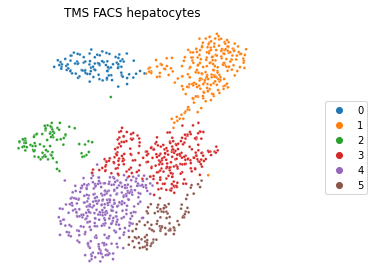

In [6]:
# Figure 
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(dic_data_proc['facs'].obs['leiden'])
print('n_cell=%d'%df_plot.shape[0])

plt.figure(figsize=[5.5,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden', s=8)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('TMS FACS hepatocytes')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/hep_tms_annot_umap.svg')
# plt.savefig(FIG_PATH+'/hep_tms_annot_umap.png')
plt.show()

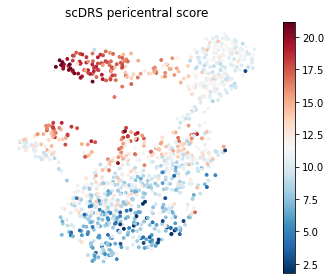

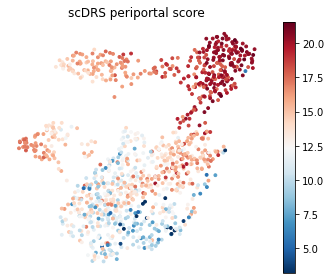

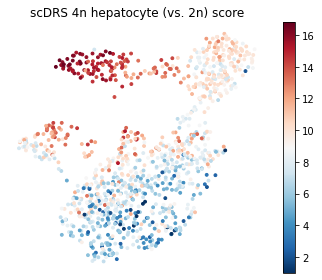

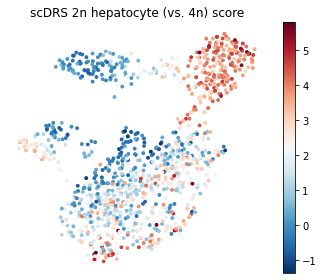

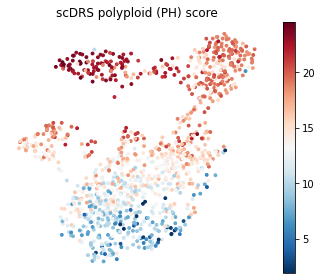

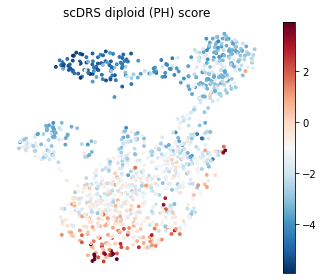

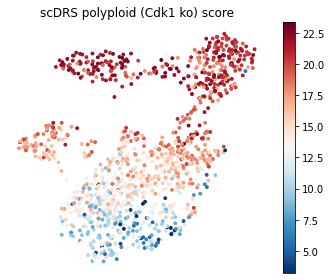

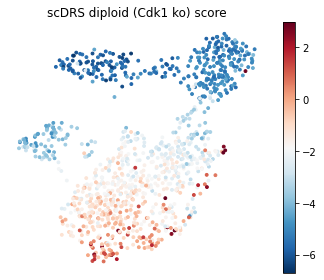

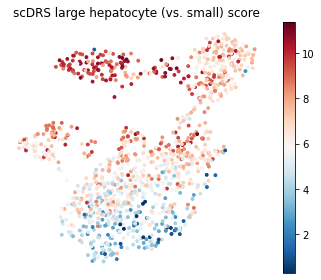

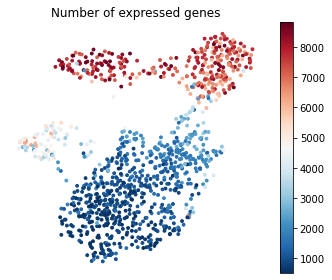

In [7]:
# UMAP for hep signatures  
ds = 'facs'
plot_list = ['CV', 'PN', 'hep4n_richter', 'hep2n_richter', 'case_96hPH_vs_prePH', 'case_prePH_vs_96hPH',
             'case_vs_ctrl_96hPH', 'ctrl_vs_case_96hPH', 'large_vs_small', 'n_genes']
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(dic_data_proc['facs'].obs)
df_plot = df_plot.join(dic_score['%s.hm'%ds])
df_plot = df_plot.loc[dic_cell_list[ds]]

for trait in plot_list:

    plt.figure(figsize=[4.8,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    
    term = '%s.norm_score'%trait if trait!='n_genes' else 'n_genes'
    title = 'scDRS %s score'%DF_TRAIT_INFO.loc[trait, 'Code'] \
        if trait!='n_genes' else 'Number of expressed genes'
    
    vmax = np.quantile(df_plot[term], 0.99) + 0.5
    vmin = np.quantile(df_plot[term], 0.01) - 0.5
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[term],
                cmap='RdBu_r', vmin=vmin, vmax=vmax, s=8)
    plt.colorbar()
    plt.title(title)

    plt.tight_layout()
    plt.savefig(FIG_PATH+'/hepsig.%s.%s.svg'%(ds, trait))
    plt.show()

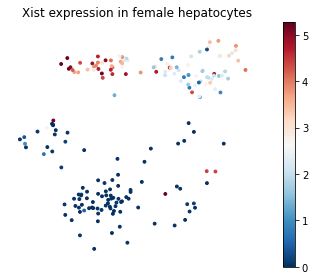

In [8]:
# Xist in female 
ds,term = 'facs','Xist'
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(dic_data_proc['facs'].obs)
df_plot['Xist'] = dic_data_proc['facs'][:,'Xist'].X.toarray()

plt.figure(figsize=[4.8,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
vmax = np.quantile(df_plot[term], 0.99) + 0.5
ind_select = df_plot['sex']=='female'
plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'], c='k', s=0, alpha=0.1)
plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], c=df_plot.loc[ind_select, term],
            cmap='RdBu_r', vmin=0, vmax=vmax, s=8)
plt.colorbar()
plt.title('Xist expression in female hepatocytes')
plt.tight_layout()
plt.savefig(FIG_PATH+'/hepsig.%s.Xist_female.svg'%(ds))
plt.show()

### Subpolulation of associated cells 

# TG associated cells=593/1102


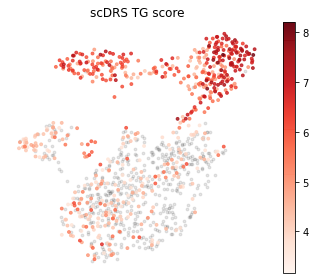

# HDL associated cells=177/1102


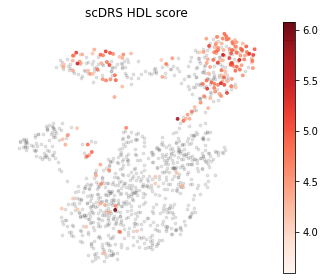

# LDL associated cells=697/1102


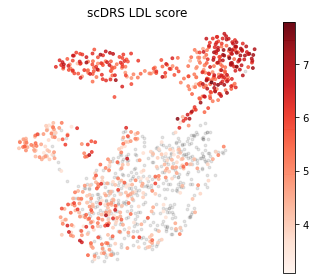

# TC associated cells=615/1102


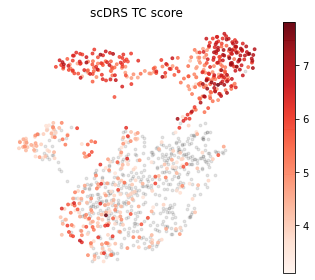

# TST associated cells=293/1102


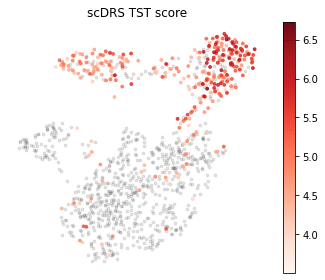

# ALT associated cells=389/1102


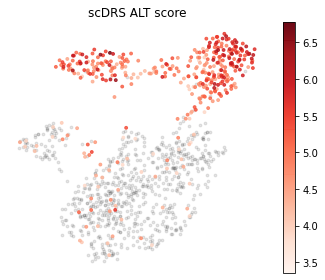

# ALP associated cells=334/1102


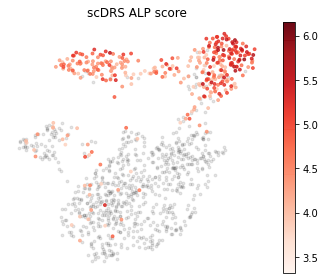

# SHBG associated cells=107/1102


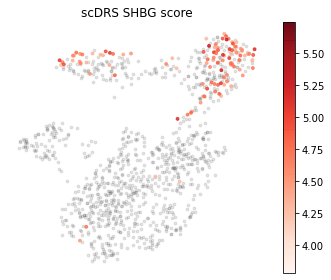

# TBIL associated cells=0/1102


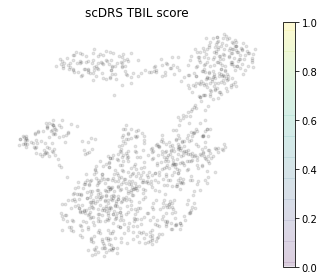

# Height associated cells=0/1102


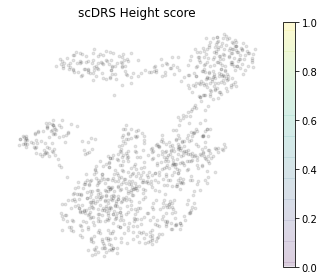

In [9]:
ds = 'facs'
for trait in DIC_TRAIT_LIST['facs']:
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                 'leiden_anno':dic_data_proc[ds].obs['leiden']})
    df_plot = df_plot.loc[dic_cell_list[ds]]
    df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
    df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

    ind_select = df_plot['%s.fdr'%trait]<0.1
    print('# %s associated cells=%d/%d'%(DF_TRAIT_INFO.loc[trait, 'Code'], ind_select.sum(), ind_select.shape[0]))

    plt.figure(figsize=[4.8,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', s=8, alpha=0.1)
    if ind_select.sum()>0:
        vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
        vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
        plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                    c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                    cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
    plt.colorbar()
    plt.title('scDRS %s score'%DF_TRAIT_INFO.loc[trait, 'Code'])

    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
    plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.png'%(ds, trait))
    plt.show()

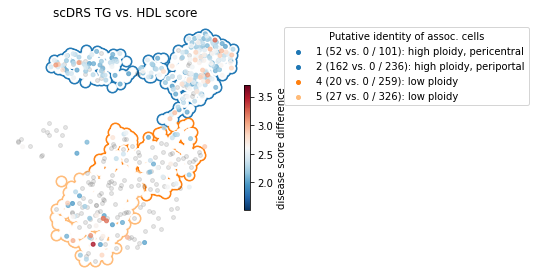

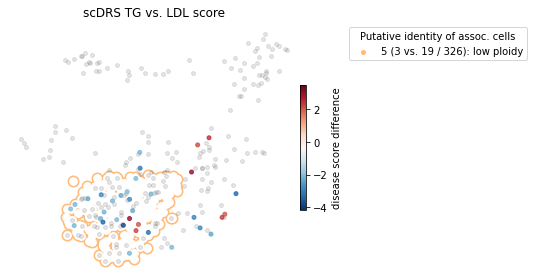

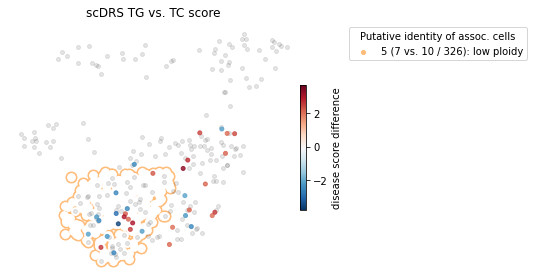

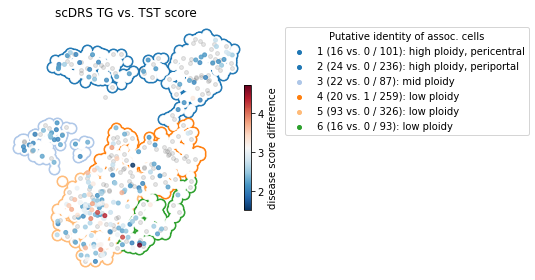

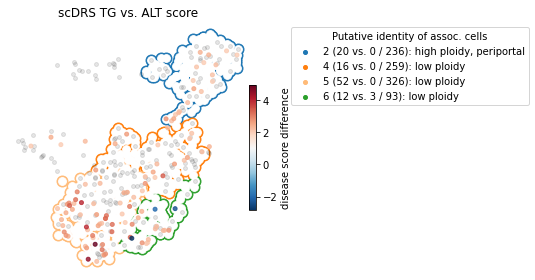

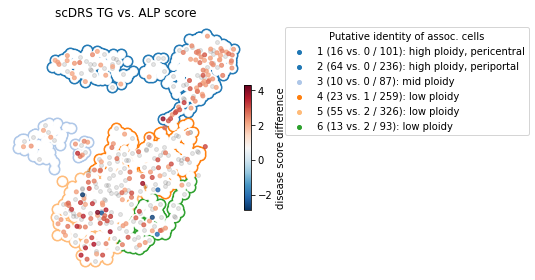

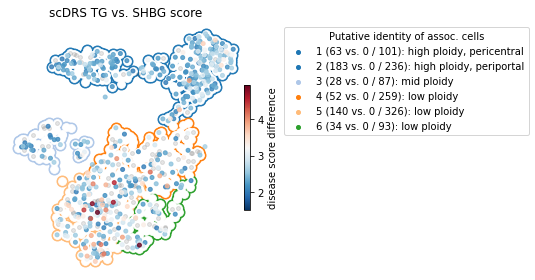

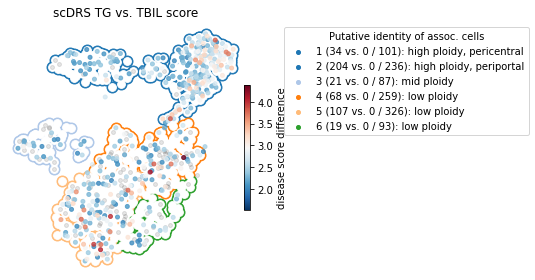

In [10]:
# UMAP for score differences of IBD vs. other pairs
def num2str(x):
    return '%d'%x if x>=25 else '-'
cmap = matplotlib.cm.get_cmap('tab20')

dic_config = {
    '0.sig' : ['1 @a: high ploidy, pericentral'], 
    '1.sig' : ['2 @a: high ploidy, periportal'],
    '2.sig' : ['3 @a: mid ploidy'],
    '3.sig' : ['4 @a: low ploidy'],
    '4.sig' : ['5 @a: low ploidy'],
    '5.sig' : ['6 @a: low ploidy'],
}

trait1 = 'UKB_460K.biochemistry_Triglycerides'

for trait2 in DIC_TRAIT_LIST['facs']:
    if trait2 in ['UKB_460K.biochemistry_Triglycerides', 'UKB_460K.body_HEIGHTz']:
        continue
    # Get df_plot     
    df_plot = pd.DataFrame(index = dic_data_proc['facs'].obs_names, 
                           data={'UMAP1' : dic_data_proc['facs'].obsm['X_umap'][:,0],
                                 'UMAP2' : dic_data_proc['facs'].obsm['X_umap'][:,1]})
    df_plot = df_plot.join(dic_data_proc['facs'].obs[['leiden', 'cell']])
    df_plot = df_plot.join(dic_score['facs'][['%s.norm_score'%trait1, '%s.norm_score'%trait2]])
    df_plot['norm_score_dif'] = df_plot['%s.norm_score'%trait1] - df_plot['%s.norm_score'%trait2]
    df_plot['abs_norm_score_dif'] = np.absolute(df_plot['norm_score_dif'])
    df_plot.sort_values('abs_norm_score_dif', ascending=True, inplace=True)

    df_plot['leiden_sig1'] = ['%s.sig'%x if y>2 else 'nonsig'
                              for x,y in zip(df_plot['leiden'], df_plot['norm_score_dif'])]
    df_plot['leiden_sig2'] = ['%s.sig'%x if y<-2 else 'nonsig'
                              for x,y in zip(df_plot['leiden'], df_plot['norm_score_dif'])]
    df_plot['leiden_sig'] = ['%s.sig'%x if y>2 else 'nonsig'
                              for x,y in zip(df_plot['leiden'], df_plot['abs_norm_score_dif'])]
    
    # Supp. fig
    temp_df = df_plot.groupby('leiden_sig').agg({'cell' : len})
    group_list = list(temp_df.index[temp_df['cell']>=10])
#     dic_config = { x : ['%s @a'%x.split('.')[0]] for x in group_list}
#         title_ = 'Clusters'
#         figsize_ = [6.5,4]
    
    group_list = [int(x.replace('.sig','')) for x in group_list if x!='nonsig']
    group_list = ['%d.sig'%x for x in sorted(group_list)]
   
    # Figure 
    plt.figure(figsize=[7.5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')

    # Cluster boundry 
    x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
    y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
    for cluster in group_list:
        ind_select = df_plot['leiden']==cluster.split('.')[0]
        assoc_str = '(%s vs. %s / %s)'%(
            (ind_select&(df_plot['leiden_sig1']!='nonsig')).sum(), 
            (ind_select&(df_plot['leiden_sig2']!='nonsig')).sum(),
            ind_select.sum()
        )
        temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
        xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
        xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
        ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
        ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
        ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                        (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                    s=16, color=cmap(int(cluster.split('.')[0])-1),
                    label=dic_config[cluster][0].replace('@a',assoc_str), zorder=0)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=120, color=cmap(int(cluster.split('.')[0])-1), zorder=1)
        plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                    s=60, color='w', zorder=2)
    
    # Grey for non-sig cells 
    np.random.seed(0)
    ind_select_sig = (df_plot['leiden_sig']!='nonsig')
    cell_list_nonsig = np.random.choice(
        df_plot.index[~ind_select_sig], size=int((~ind_select_sig).sum()*0.2), replace=False)
    plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)
    
    # Red for sig cells 
    vmax = np.quantile(df_plot.loc[ind_select_sig, 'norm_score_dif'], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select_sig, 'norm_score_dif'], 0.01) - 0.5
    plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
                c=df_plot.loc[ind_select_sig, 'norm_score_dif'],
                cmap='RdBu_r', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
    plt.colorbar(shrink=0.5, pad=0, label='disease score difference')
    plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left',
               title='Putative identity of assoc. cells')
    plt.title('scDRS %s vs. %s score'%(DF_TRAIT_INFO.loc[trait1, 'Code'], DF_TRAIT_INFO.loc[trait2, 'Code']))

    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc_dif.%s.%s.svg'%(trait1, trait2))
    plt.savefig(FIG_PATH+'/sctrs_assoc_dif.%s.%s.png'%(trait1, trait2))
    plt.show()

### Annotation for TG associated cells 

# Removed: Hsl
# Removed: Dgat


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue_celltype' as categorical
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leiden_sig' as categorical


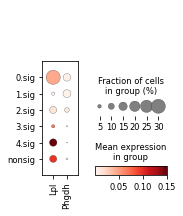

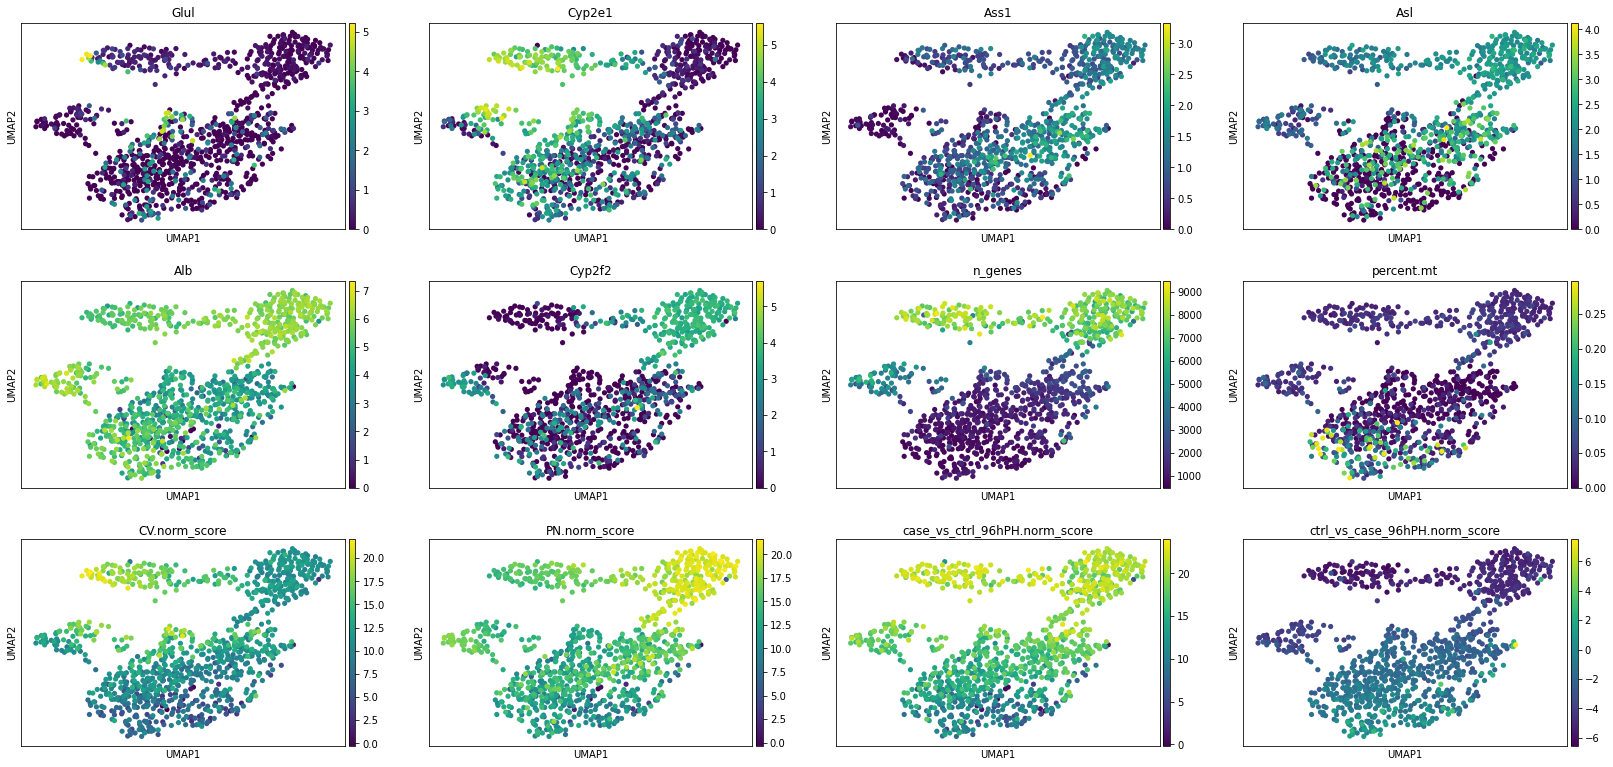

In [11]:
trait = 'UKB_460K.biochemistry_Triglycerides'
ds = 'facs'

# Assign sig label for each leiden cluster (remove sig cells in small clusters)
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm

adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
                           for x,y in zip(adata.obs['leiden'], adata.obs['%s.fdr'%trait])]

temp_df = adata.obs.groupby(['leiden_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<25])
adata.obs.loc[adata.obs['leiden_sig'].isin(cluster_remove_list), 'leiden_sig'] = 'nonsig' 

# Specifically expressed genes 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
# sc.tl.rank_genes_groups(adata, groupby='leiden_sig', reference='rest', groups=group_list+['nonsig'])
# sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

# Marker gene expression 
marker_list = ['Lpl', 'Hsl', 'Dgat', 'Phgdh', # TG regulation
#                'Vldlr', 'Ldlr', 'Lrp1', 'Scarb1', 'Srebf2', 'Scap', 'Pcsk9', 'Sar1b', 'Itgav', 
#                'Adipoq', 'App', 'Itgb3', 'Psen1', 'Hnrnpk', 'Anxa2', 'Pparg', 'Cnpy2', # Lipoprotein receptor
#                'Alb', # Plasma protein secretion
#                'Fgb', 'F2', 'F9', 'Kng1', 'Aplp2', # Blood clotting factors 
#                'Gc', # Vitamin D
#                'G6pc', # Glycogenolysis and gluconeogenesis
#                'Cyp', 'Glul', 'Oat', 'Ces3a', 'Slc22a1', 'Aldh3a2', # Detoxification
#                'Akr1c6', 'Abcb4', # Bile acid synthesis
#                'Blvrb', # Heme synthesis
#                'Csad', # Amino acid metabolism
#                'Rgn', # Calcium homeostasis
#                'Hmgcl', # Ketogenesis
#                'Stard10', 'Apoa', 'Apoc', # Hormone, vitamin, and lipid transport
#                'Hmgcs2', 'Aldh2', 'Ppara', 'MGll', # Cholesterol, alcohol and lipid metabolism
#                'Agt', 'Igfbp2', 'Igfbp4', # Hormone synthesis and secretion
#                'Hamp', 'Ftl1', 'Hp', # Iron homeostasis and storage
#                'Ass1', 'Asl', # Urea synthesis from ammonia 
#                'Gpx1', # Glutathione synthesis 
#                'Pck1', 'Fbp1', # Gluconeogenesis
#                'Arg1', # Urea synthesis from arginine
#                'Cat', # Catalase production
#                'Cox', 'Nduf' # Respiration (b-oxidation)
#                'Glul', 'Apoe', 'Cyp1a2', 'Cyp2e1', 'Cyp2f2', 'Cyp2e1', # Central
#                'Arg1', 'Alb', 'Pck1' # Periportal
              ]
for gene in marker_list.copy():
    if gene not in adata.var_names:
        marker_list.remove(gene)
        print('# Removed: %s'%gene)
sc.pl.dotplot(adata, marker_list, groupby='leiden_sig')

# Zonation markers
marker_list = ['Glul', 'Cyp2e1', 'Ass1', 'Asl', 'Alb', 'Cyp2f2',
               'n_genes', 'percent.mt', 'CV.norm_score', 'PN.norm_score',
               'case_vs_ctrl_96hPH.norm_score', 'ctrl_vs_case_96hPH.norm_score']
adata.obs = adata.obs.join(dic_score['facs.hm'][['CV.norm_score', 'PN.norm_score',
                                                 'case_vs_ctrl_96hPH.norm_score', 'ctrl_vs_case_96hPH.norm_score']])
sc.pl.umap(adata, color=marker_list)

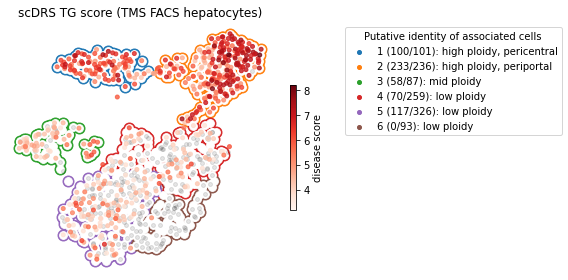

In [12]:
# UMAP plot with annotations 
ds='facs'
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
dic_config = {'0': ['C0', '1 @a: high ploidy, pericentral'],
              '1': ['C1', '2 @a: high ploidy, periportal'],
              '2': ['C2', '3 @a: mid ploidy'], 
              '3': ['C3', '4 @a: low ploidy'], 
              '4': ['C4', '5 @a: low ploidy'],
              '5': ['C5', '6 @a: low ploidy']
             }

# Get df_plot 
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['leiden', 'leiden_sig']])
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

# Figure 
plt.figure(figsize=[8,4])
ax = plt.subplot(1,1,1)
ax.axis('off')

# Cluster boundry 
x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
for cluster in dic_config:
    ind_select = df_plot['leiden']==cluster
    n_sig,n_tot = (df_plot['leiden_sig']=='%s.sig'%cluster).sum(),ind_select.sum()
    temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
    xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
    xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
    ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
    ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
    ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                    (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                s=16, color=dic_config[cluster][0], 
                label=dic_config[cluster][1].replace('@a', '(%d/%d)'%(n_sig,n_tot)), 
                zorder=0)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=120, color=dic_config[cluster][0], zorder=1)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=60, color='w', zorder=2)

ind_select_sig = (df_plot['leiden_sig']!='nonsig')
np.random.seed(0)
cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
                                    size=int((~ind_select_sig).sum()*0.5), replace=False)
plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)

vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
            c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
            cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
plt.colorbar(shrink=0.5, label='disease score')
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left', title='Putative identity of associated cells')
plt.title('scDRS %s score (TMS FACS hepatocytes)'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.tight_layout()
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_%s_umap.svg'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_%s_umap.png'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.show()

### Overlap of ploidy signatures and disease gene sets

In [13]:
DF_PLOIDY = pd.read_csv(DATA_PATH+'/gs_file/ploidy.gs', sep='\t', index_col=0)
trait_ploidy = 'case_96hPH_vs_prePH'
bkgrd_gs = set(DIC_MAP_H2M.keys())
v_or = []
for trait in DIC_TRAIT_LIST['facs']:
    trait_gs = {x.split(':')[0] for x in DF_GS.loc[trait, 'GENESET'].split(',')}
    ploidy_gs = {x.split(':')[0] for x in DF_PLOIDY.loc[trait_ploidy, 'GENESET'].split(',')}
    pvalue, oddsratio, or_ub, or_lb = scdrs.util.test_overlap(trait_gs, ploidy_gs, bkgrd_gs)
    if trait != 'UKB_460K.body_HEIGHTz':
        v_or.append(oddsratio)
    print('{:^15s} {:^10s} {:^20s} {:^20s} {:^20s}'.format(
        trait_ploidy,
        DF_TRAIT_INFO.loc[trait, 'Code'],
        '%d/%d/%d'%(len(trait_gs&ploidy_gs), len(ploidy_gs), len(trait_gs)), 
        'OR=%0.2f (%0.2f-%0.2f)'%(oddsratio, or_lb, or_ub), 
        'P=%0.2e'%pvalue
    ))
print('OR: mean=%0.2f, SE=%0.2f'%(np.mean(v_or), np.std(v_or) / np.sqrt(len(v_or))))
print('')

case_96hPH_vs_prePH     TG         51/471/1000      OR=1.94 (1.44-2.61)       P=4.78e-05     
case_96hPH_vs_prePH    HDL         27/471/1000      OR=0.95 (0.64-1.40)       P=9.22e-01     
case_96hPH_vs_prePH    LDL         37/471/1000      OR=1.34 (0.95-1.89)       P=9.50e-02     
case_96hPH_vs_prePH     TC         38/471/1000      OR=1.38 (0.99-1.94)       P=6.22e-02     
case_96hPH_vs_prePH    TST         36/471/1000      OR=1.30 (0.92-1.84)       P=1.40e-01     
case_96hPH_vs_prePH    ALT         39/471/1000      OR=1.42 (1.02-1.99)       P=4.85e-02     
case_96hPH_vs_prePH    ALP         44/471/1000      OR=1.63 (1.19-2.24)       P=4.14e-03     
case_96hPH_vs_prePH    SHBG        47/471/1000      OR=1.76 (1.30-2.40)       P=7.50e-04     
case_96hPH_vs_prePH    TBIL        39/471/1000      OR=1.43 (1.02-1.99)       P=4.84e-02     
case_96hPH_vs_prePH   Height       32/471/1000      OR=1.14 (0.79-1.64)       P=4.91e-01     
OR: mean=1.46, SE=0.09



### Joint regression analysis based on covariates 

In [14]:
# Validate ploidy score
n_ctrl = 1000
for ploidy_term in ['hep4n_richter', 'case_96hPH_vs_prePH', 'case_vs_ctrl_96hPH', 'large_vs_small', 
                    'hep2n_richter', 'case_prePH_vs_96hPH', 'ctrl_vs_case_96hPH']:
    df_reg = dic_data_proc['richter'].obs.copy()
    df_reg['ploidy'] = (df_reg['Ploidy']=='4n')*1
    df_reg = df_reg.join(dic_score['richter.hm'][['%s.norm_score'%ploidy_term]])
    df_reg = df_reg.join(dic_ctrl_score['richter.hm'][ploidy_term])

    corr_ = np.corrcoef(df_reg['ploidy'], df_reg['%s.norm_score'%ploidy_term])[0,1]
    v_corr_ = np.zeros(n_ctrl) 
    for i in range(n_ctrl):
        v_corr_[i] = np.corrcoef(df_reg['ploidy'], df_reg['ctrl_norm_score_%d'%i])[0,1]
    if ploidy_term in ['hep4n_richter', 'case_96hPH_vs_prePH', 'case_vs_ctrl_96hPH', 'large_vs_small']:
        p_=((corr_ <= v_corr_).sum()+1) / (n_ctrl+1)
    else:
        p_=((corr_ >= v_corr_).sum()+1) / (n_ctrl+1)
    print('# Richter Ploidy and %-20s: Corr.=%0.2f P=%0.3f'%(ploidy_term, corr_, p_))
print('')

# Validate CV/PN score
for comparison_term in [['CV', 'Layer 1'], ['PN', 'Layer 9']]:
    term,annot = comparison_term
    df_reg = dic_data_proc['halpern'].obs.copy()
    df_reg = df_reg.join(dic_score['halpern.hm'][['%s.norm_score'%term]])
    df_reg = df_reg.join(dic_ctrl_score['halpern.hm'][term])
    corr_ = np.corrcoef(df_reg[annot], df_reg['%s.norm_score'%term])[0,1]
    v_corr_ = np.zeros(n_ctrl) 
    for i in range(n_ctrl):
        v_corr_[i] = np.corrcoef(df_reg[annot], df_reg['ctrl_norm_score_%d'%i])[0,1]
        p_=((corr_ <= v_corr_).sum()+1) / (n_ctrl+1)
    print('# Halpern %s and %-20s: Corr.=%0.2f P=%0.3f'%(annot, term, corr_, p_))
print('')
    
for term in ['CV', 'PN']:
    df_reg = dic_data_proc['aizarani'].obs.copy()
    df_reg = df_reg.join(dic_score['aizarani.hm'][['%s.norm_score'%term]])
    df_reg = df_reg.join(dic_ctrl_score['aizarani.hm'][term])
    corr_ = np.corrcoef(df_reg['zonation'], df_reg['%s.norm_score'%term])[0,1]
    v_corr_ = np.zeros(n_ctrl) 
    for i in range(n_ctrl):
        v_corr_[i] = np.corrcoef(df_reg['zonation'], df_reg['ctrl_norm_score_%d'%i])[0,1]
        p_=((corr_ <= v_corr_).sum()+1) / (n_ctrl+1)
    print('# Aizarani zonation and %-20s: Corr.=%0.2f P=%0.3f'%(term, corr_, p_))

# Richter Ploidy and hep4n_richter       : Corr.=0.48 P=0.001
# Richter Ploidy and case_96hPH_vs_prePH : Corr.=0.28 P=0.001
# Richter Ploidy and case_vs_ctrl_96hPH  : Corr.=0.20 P=0.001
# Richter Ploidy and large_vs_small      : Corr.=0.25 P=0.001
# Richter Ploidy and hep2n_richter       : Corr.=-0.59 P=0.001
# Richter Ploidy and case_prePH_vs_96hPH : Corr.=-0.20 P=0.001
# Richter Ploidy and ctrl_vs_case_96hPH  : Corr.=-0.15 P=0.001

# Halpern Layer 1 and CV                  : Corr.=0.42 P=0.001
# Halpern Layer 9 and PN                  : Corr.=0.45 P=0.001

# Aizarani zonation and CV                  : Corr.=-0.12 P=0.874
# Aizarani zonation and PN                  : Corr.=0.11 P=0.201


In [15]:
# Consistency of ploidy score 
ploidy_term = 'case_96hPH_vs_prePH'
ploidy_term_list = ['hep4n_richter', 'case_vs_ctrl_96hPH', 'large_vs_small',
                    'hep2n_richter', 'ctrl_vs_case_96hPH', 'case_prePH_vs_96hPH']
ds_list = DS_LIST
df_stats_ploidy = pd.DataFrame(index=ploidy_term_list, columns=ds_list, dtype=float)
df_stats_ploidy_corr = pd.DataFrame(index=ploidy_term_list, columns=ds_list, dtype=float)

for ds in ds_list:
    for term in ploidy_term_list:
        df_reg = dic_score['%s.hm'%ds].loc[dic_cell_list[ds], 
                                           ['%s.norm_score'%ploidy_term, '%s.norm_score'%term]].copy()
        df_reg = df_reg.join(dic_ctrl_score['%s.hm'%ds][term])

        corr_ = np.corrcoef(df_reg['%s.norm_score'%ploidy_term], df_reg['%s.norm_score'%term])[0,1]
        v_corr_ = np.zeros(n_ctrl) 
        for i in range(n_ctrl):
            v_corr_[i] = np.corrcoef(df_reg['%s.norm_score'%ploidy_term], df_reg['ctrl_norm_score_%d'%i])[0,1]
        if term in ['hep4n_richter', 'case_96hPH_vs_prePH', 'case_vs_ctrl_96hPH', 'large_vs_small']:
            p_=((corr_ <= v_corr_).sum()+1) / (n_ctrl+1)
        else:
            p_=((corr_ >= v_corr_).sum()+1) / (n_ctrl+1)
        df_stats_ploidy.loc[term, ds] = p_
        df_stats_ploidy_corr.loc[term, ds] = corr_
display(df_stats_ploidy)
display(df_stats_ploidy_corr)

# Make table 
df_res = df_stats_ploidy.copy()
df_res.index = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_res.index]
df_res.columns = [DIC_INFO[x]['dname'].replace('&','\&') for x in df_res.columns]
for col in df_res.columns:
    df_res[col] = ['$\textbf{%0.3f}$'%x if x<0.005 else '$%0.3f$'%x for x in df_res[col]]
print(df_res.to_latex(index=True, escape=False, column_format='|c|cccccc|'))

,facs,droplet,aizarani,halpern,richter,rao
hep4n_richter,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999
case_vs_ctrl_96hPH,0.000999,0.000999,0.000999,0.037962,0.000999,0.000999
large_vs_small,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999
hep2n_richter,0.469530,0.008991,0.542458,0.002997,0.000999,0.013986
ctrl_vs_case_96hPH,0.000999,0.000999,0.320679,0.027972,0.000999,0.147852
case_prePH_vs_96hPH,0.000999,0.000999,0.155844,0.000999,0.001998,0.000999


,facs,droplet,aizarani,halpern,richter,rao
hep4n_richter,0.867225,0.746865,0.757569,0.533213,0.755363,0.640782
case_vs_ctrl_96hPH,0.951752,0.750564,0.924232,0.229320,0.796310,0.779700
large_vs_small,0.904177,0.802704,0.846701,0.559731,0.702469,0.769175
hep2n_richter,-0.032090,-0.429106,0.014363,-0.406347,-0.370499,-0.281225
ctrl_vs_case_96hPH,-0.826634,-0.665301,-0.071020,-0.161664,-0.220008,-0.107184
case_prePH_vs_96hPH,-0.845999,-0.762409,-0.164997,-0.454703,-0.183386,-0.333519


\begin{tabular}{|c|cccccc|}
\toprule
{} &          TMS FACS &       TMS Droplet &          Aizarani & Halpern \& Shenhav & Richter \& Deligiannis & Taychameekiatchai \\
\midrule
4n hepatocyte (vs. 2n)       &  $\textbf{0.001}$ &  $\textbf{0.001}$ &  $\textbf{0.001}$ &   $\textbf{0.001}$ &       $\textbf{0.001}$ &  $\textbf{0.001}$ \\
polyploid (Cdk1 ko)          &  $\textbf{0.001}$ &  $\textbf{0.001}$ &  $\textbf{0.001}$ &            $0.038$ &       $\textbf{0.001}$ &  $\textbf{0.001}$ \\
large hepatocyte (vs. small) &  $\textbf{0.001}$ &  $\textbf{0.001}$ &  $\textbf{0.001}$ &   $\textbf{0.001}$ &       $\textbf{0.001}$ &  $\textbf{0.001}$ \\
2n hepatocyte (vs. 4n)       &           $0.470$ &           $0.009$ &           $0.542$ &   $\textbf{0.003}$ &       $\textbf{0.001}$ &           $0.014$ \\
diploid (Cdk1 ko)            &  $\textbf{0.001}$ &  $\textbf{0.001}$ &           $0.321$ &            $0.028$ &       $\textbf{0.001}$ &           $0.148$ \\
diploid (PH)                 &  

In [16]:
# Prepare regression datasets 
dic_cov = {}
ploidy_term = 'case_96hPH_vs_prePH'

# FACS all 
dic_cov['facs'] = dic_data_proc['facs'].obs.copy()
dic_cov['facs']['ploidy'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, '%s.norm_score'%ploidy_term]
dic_cov['facs']['CV'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, 'CV.norm_score']
dic_cov['facs']['PN'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, 'PN.norm_score']

# droplet 
dic_cov['droplet'] = dic_data_proc['droplet'].obs.copy()
dic_cov['droplet']['ploidy'] = dic_score['droplet.hm'].loc[dic_cov['droplet'].index, '%s.norm_score'%ploidy_term]
dic_cov['droplet']['CV'] = dic_score['droplet.hm'].loc[dic_cov['droplet'].index, 'CV.norm_score']
dic_cov['droplet']['PN'] = dic_score['droplet.hm'].loc[dic_cov['droplet'].index, 'PN.norm_score']

# aizarani
dic_cov['aizarani'] = dic_data_proc['aizarani'].obs.copy()
dic_cov['aizarani']['ploidy'] = dic_score['aizarani.hm'].loc[dic_cov['aizarani'].index, '%s.norm_score'%ploidy_term]
dic_cov['aizarani']['CV'] = dic_score['aizarani.hm'].loc[dic_cov['aizarani'].index, 'CV.norm_score']
dic_cov['aizarani']['PN'] = dic_score['aizarani.hm'].loc[dic_cov['aizarani'].index, 'PN.norm_score']

# halpern
dic_cov['halpern'] = dic_data_proc['halpern'].obs.copy()
dic_cov['halpern']['ploidy'] = dic_score['halpern.hm'].loc[dic_cov['halpern'].index, '%s.norm_score'%ploidy_term]
dic_cov['halpern']['CV'] = dic_score['halpern.hm'].loc[dic_cov['halpern'].index, 'CV.norm_score']
dic_cov['halpern']['PN'] = dic_score['halpern.hm'].loc[dic_cov['halpern'].index, 'PN.norm_score']

# richter
dic_cov['richter'] = dic_data_proc['richter'].obs.copy()
dic_cov['richter']['gt_ploidy'] = (dic_cov['richter']['Ploidy']=='4n')*1
dic_cov['richter']['ploidy'] = dic_score['richter.hm'].loc[dic_cov['richter'].index, '%s.norm_score'%ploidy_term]
dic_cov['richter']['CV'] = dic_score['richter.hm'].loc[dic_cov['richter'].index, 'CV.norm_score']
dic_cov['richter']['PN'] = dic_score['richter.hm'].loc[dic_cov['richter'].index, 'PN.norm_score']

# # richter_Ploidy
# dic_cov['richter_Ploidy'] = dic_data_proc['richter'].obs.copy()
# dic_cov['richter_Ploidy']['ploidy'] = (dic_cov['richter_Ploidy']['Ploidy']=='4n')*1
# dic_cov['richter_Ploidy']['CV'] = dic_score['richter.hm'].loc[dic_cov['richter_Ploidy'].index, 'CV.norm_score']
# dic_cov['richter_Ploidy']['PN'] = dic_score['richter.hm'].loc[dic_cov['richter_Ploidy'].index, 'PN.norm_score']

# rao
dic_cov['rao'] = dic_data_proc['rao'].obs.copy()
dic_cov['rao']['ploidy'] = dic_score['rao.hm'].loc[dic_cov['rao'].index, '%s.norm_score'%ploidy_term]
dic_cov['rao']['CV'] = dic_score['rao.hm'].loc[dic_cov['rao'].index, 'CV.norm_score']
dic_cov['rao']['PN'] = dic_score['rao.hm'].loc[dic_cov['rao'].index, 'PN.norm_score']

# Add const and leiden
for cov_name in dic_cov:
    dic_cov[cov_name]['const'] = 1
    for cluster in set(dic_cov[cov_name]['leiden']):
        dic_cov[cov_name]['leidenreg_%s'%cluster] = (dic_cov[cov_name]['leiden']==cluster)*1
    
# Regout ploidy from CV/PN
for cov_name in dic_cov:
    mat_Y = np.ones([dic_cov[cov_name].shape[0],2])
    mat_Y[:,1] = dic_cov[cov_name]['ploidy']
    dic_cov[cov_name]['CV'] = scdrs.pp.reg_out(dic_cov[cov_name]['CV'], mat_Y)
    dic_cov[cov_name]['PN'] = scdrs.pp.reg_out(dic_cov[cov_name]['PN'], mat_Y)
    print('%s CV-PN corr.=%0.3f'%(cov_name, np.corrcoef(dic_cov[cov_name]['CV'], dic_cov[cov_name]['PN'])[0,1]))


facs CV-PN corr.=-0.666
droplet CV-PN corr.=-0.774
aizarani CV-PN corr.=0.056
halpern CV-PN corr.=-0.912
richter CV-PN corr.=-0.417
rao CV-PN corr.=-0.686


In [17]:
dic_reg = {'reg_joint': ['ploidy', 'CV', 'PN'], 
#            'reg_joint_cluster': ['ploidy', 'CV', 'PN']
          }
trait_black_list = ['CV', 'PN', ploidy_term]

dic_stats = {}
for cov_name in dic_cov:
    for reg_name in dic_reg:
        
        if reg_name.endswith('_cluster'):
            ctrl_list = ['const'] + [x for x in dic_cov[cov_name].columns if 'leidenreg' in x]
        else:
            ctrl_list = ['const']
        print(cov_name, reg_name, ','.join(ctrl_list))
        
        reg_list = dic_reg[reg_name]
        df_stats = pd.DataFrame(columns=['var_ctrl','var']+['%s.%s'%(y,x) for x in reg_list for y in ['T', 'P']])
        ds = cov_name.split('_' )[0]
        
        for score in [ds, ds+'.hm']:
            for trait in DIC_TRAIT_LIST[score]:
                if '%s.norm_score'%trait not in dic_score[score]:
                    continue
                if trait in trait_black_list:
                    continue                

                df_reg = dic_cov[cov_name][reg_list+ctrl_list].copy()
                df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
                df_reg = df_reg.join(dic_ctrl_score[score][trait])
                
                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list]).fit()
                var_explain_ctrl_ = 1 - res.mse_resid/res.mse_total

                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list+reg_list]).fit()
                var_explain_ = 1 - res.mse_resid/res.mse_total
                dic_t = {x:res.tvalues[x] for x in reg_list}
                dic_t_ctrl = {x:np.zeros(n_ctrl) for x in reg_list}

                for i in range(n_ctrl):
                    res = sm.OLS(df_reg['ctrl_norm_score_%d'%i], df_reg[ctrl_list+reg_list]).fit()
                    for reg in reg_list:
                        dic_t_ctrl[reg][i] = res.tvalues[reg]

                dic_p = {x:((dic_t[x] <= dic_t_ctrl[x]).sum()+1) / (n_ctrl+1) for x in reg_list} 
                df_stats.loc[trait] = [var_explain_ctrl_, var_explain_] + \
                    [y[x] for x in reg_list for y in [dic_t, dic_p]]

        for reg_term in reg_list:
            df_stats['P_STR.%s'%reg_term] = [scdrs.util.p_2_str(x) for x in df_stats['P.%s'%reg_term]]
            df_stats['P_STR_NUM.%s'%reg_term] = [scdrs.util.p_2_str_num(x, n_ctrl) for x in df_stats['P.%s'%reg_term]]
        dic_stats['%s.%s'%(cov_name, reg_name)] = df_stats

facs reg_joint const
droplet reg_joint const
aizarani reg_joint const
halpern reg_joint const
richter reg_joint const
rao reg_joint const


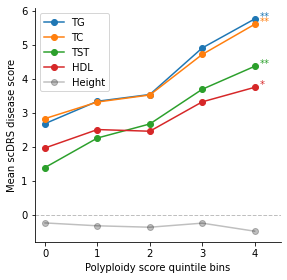

In [22]:
# Ploidy results for FACs GWAS traits
trait_list = ['UKB_460K.biochemistry_Testosterone_Male',
              'UKB_460K.biochemistry_Triglycerides',
              'UKB_460K.biochemistry_HDLcholesterol', 
              'UKB_460K.biochemistry_Cholesterol',
              'UKB_460K.body_HEIGHTz'
             ]
df_plot = dic_cov['facs'][['ploidy']].copy()
df_plot = df_plot.join(dic_score['facs'][['%s.norm_score'%x for x in trait_list]])
df_plot['bin'] = pd.qcut(df_plot['ploidy'], q=5, labels=False)

# Reorder traits 
cell_list = df_plot.index[df_plot['ploidy']>np.quantile(df_plot['ploidy'], 0.8)]
temp_df = pd.DataFrame(index=trait_list,
                       data={'score': [dic_score['facs'].loc[cell_list, '%s.norm_score'%x].mean()
                                       for x in trait_list]})
temp_df.sort_values(by='score', ascending=False, inplace=True)
trait_list = list(temp_df.index)

i_color = 0
y_text = 8
plt.figure(figsize=[4.1,4])
ax = plt.subplot(1,1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i_trait,trait in enumerate(trait_list):
    alpha_=0.25 if trait=='UKB_460K.body_HEIGHTz' else 1
    color_='k' if trait=='UKB_460K.body_HEIGHTz' else 'C%d'%i_color
    temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
    temp_df.columns = ['mean']
    plt.plot(temp_df.index, temp_df['mean'], 'o-', label=DF_TRAIT_INFO.loc[trait, 'Code'], 
             color=color_, alpha=alpha_)
    y_text = min(y_text-0.1, temp_df['mean'][4])
    plt.text(4.1, y_text, dic_stats['facs.reg_joint'].loc[trait,'P_STR.ploidy'], color='C%d'%i_color)
    i_color += 1
    
plt.axhline(y=0, ls="--", color="k", lw=1, alpha=0.25)
plt.xlim([-0.2,4.5])
plt.legend()
plt.xlabel('Polyploidy score quintile bins')
plt.ylabel('Mean scDRS disease score')
plt.tight_layout()
plt.savefig(FIG_PATH+'/hepreg.ploidy.facs.svg')
plt.show()

In [19]:
# Supp. Table for the TMS FACS results
reg_name = 'reg_joint'
trait_list = DIC_TRAIT_LIST['facs']
ds ='facs'
dic_name = {'P.ploidy':'Polyploidy.P', 'P.CV':'Pericentral.P', 'P.PN':'Periportal.P',
            'var': 'Variance explained'}

df_res = dic_stats['%s.%s'%(ds,reg_name)].loc[trait_list, ['P.%s'%x for x in dic_reg[reg_name]]+['var']]
df_res.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x for x in df_res.index]
df_res.columns = [dic_name[x] for x in df_res.columns]

for col in ['Polyploidy.P', 'Pericentral.P', 'Periportal.P']:
    df_res[col] = ['$\textbf{%0.3f}$'%x if x<0.005 else '$%0.3f$'%x for x in df_res[col]]
for col in ['Variance explained']:
    df_res[col] = ['%0.3f'%x for x in df_res[col]]
print(df_res.to_latex(index=True, escape=False, column_format='|c|cccc|'))

\begin{tabular}{|c|cccc|}
\toprule
{} &      Polyploidy.P & Pericentral.P &      Periportal.P & Variance explained \\
\midrule
TG     &  $\textbf{0.001}$ &       $0.730$ &           $0.009$ &              0.568 \\
HDL    &           $0.006$ &       $0.620$ &           $0.044$ &              0.422 \\
LDL    &           $0.007$ &       $0.350$ &           $0.006$ &              0.443 \\
TC     &  $\textbf{0.002}$ &       $0.434$ &  $\textbf{0.005}$ &              0.461 \\
TST    &  $\textbf{0.001}$ &       $0.781$ &  $\textbf{0.005}$ &              0.611 \\
ALT    &  $\textbf{0.001}$ &       $0.515$ &           $0.006$ &              0.615 \\
ALP    &  $\textbf{0.001}$ &       $0.480$ &  $\textbf{0.001}$ &              0.599 \\
SHBG   &  $\textbf{0.001}$ &       $0.616$ &           $0.017$ &              0.601 \\
TBIL   &  $\textbf{0.001}$ &       $0.751$ &           $0.241$ &              0.527 \\
Height &           $0.634$ &       $0.939$ &           $0.241$ &              0.115 \\
\bo

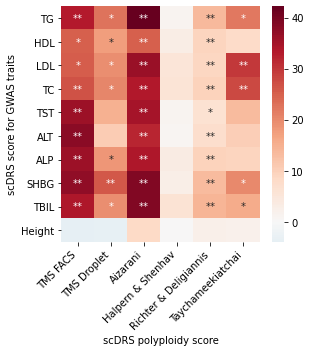

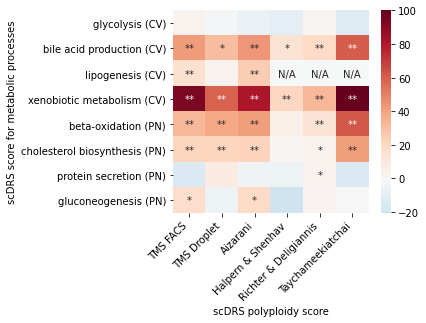

In [20]:
# Ploidy score all data
reg_name = 'reg_joint'
ds_list = DS_LIST
dic_plot_trait = {'GWAS traits': DIC_TRAIT_LIST['facs'], 
                  'metabolic processes': ['Glycolysis', 'Bile acid production', 'Lipogenesis',
                                           'Xenobiotic metabolism', 'Beta-oxidation', 'Cholesterol biosynthesis', 
                                           'Protein secretion', 'Gluconeogenesis'], 
#                   'ploidy signatures': ['hep4n_richter', 'case_vs_ctrl_96hPH', 'large_vs_small',
#                                         'hep2n_richter', 'ctrl_vs_case_96hPH', 'case_prePH_vs_96hPH'] 
                 }
for trait_name in dic_plot_trait:
    trait_list = dic_plot_trait[trait_name]
    df_plot = pd.DataFrame(index=trait_list, columns=ds_list, dtype=float)
    df_plot_annot = pd.DataFrame(index=trait_list, columns=ds_list)
    for ds in ds_list:
        temp_list = list(set(df_plot[ds].index) & set(dic_stats['%s.%s'%(ds,reg_name)].index))
        df_plot.loc[temp_list, ds] = dic_stats['%s.%s'%(ds,reg_name)].loc[temp_list, 'T.ploidy']
        df_plot_annot.loc[temp_list, ds] = dic_stats['%s.%s'%(ds,reg_name)].loc[temp_list, 'P_STR.ploidy']

    df_plot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x for x in df_plot.index]
    df_plot_annot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x 
                           for x in df_plot_annot.index]
    df_plot.fillna(0, inplace=True)
    df_plot.clip(upper=100, inplace=True)
    df_plot_annot.fillna('N/A', inplace=True)

    plt.figure(figsize=[4.5+1.5*(trait_name!='GWAS traits'), 3+0.2*df_plot.shape[0]])
    sns.heatmap(df_plot, annot=df_plot_annot, fmt='s', cmap='RdBu_r', center=0)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, [DIC_INFO[x]['dname'] for x in df_plot.columns], 
               rotation=45, ha='right')
    plt.yticks(np.arange(df_plot.shape[0])+0.5, df_plot.index)
    plt.xlabel('scDRS polyploidy score')
    plt.ylabel('scDRS score for %s'%trait_name)
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/hepreg.ploidy.%s.svg'%trait_name)
    plt.show()

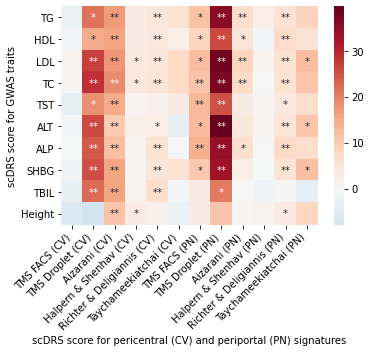

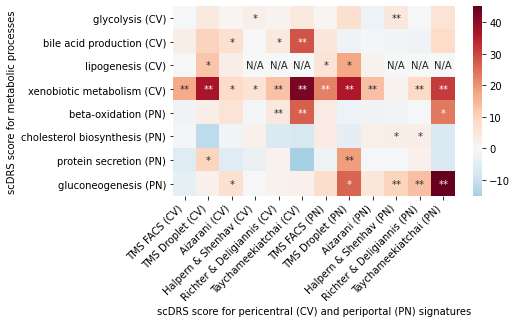

In [21]:
# CV/PN all data
ds_list = DS_LIST

for trait_name in dic_plot_trait:
    trait_list = dic_plot_trait[trait_name]
    col_list = ['%s.%s'%(x,y) for x in ['CV','PN'] for y in ds_list]
    df_plot = pd.DataFrame(index=trait_list, columns=col_list, dtype=float)
    df_plot_annot = pd.DataFrame(index=trait_list, columns=col_list)
    for col in col_list:
        hm,ds = col.split('.')
        temp_list = list(set(df_plot[col].index) & set(dic_stats['%s.%s'%(ds,reg_name)].index))
        df_plot.loc[temp_list, col] = dic_stats['%s.%s'%(ds,reg_name)].loc[temp_list, 'T.%s'%hm]
        df_plot_annot.loc[temp_list, col] = dic_stats['%s.%s'%(ds,reg_name)].loc[temp_list, 'P_STR.%s'%hm]

    df_plot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x for x in df_plot.index]
    df_plot_annot.index = [DF_TRAIT_INFO.loc[x,'Code'] if x in DF_TRAIT_INFO.index else x 
                           for x in df_plot_annot.index]
    df_plot.fillna(0, inplace=True)
    df_plot_annot.fillna('N/A', inplace=True)

    plt.figure(figsize=[5.5+2*(trait_name!='GWAS traits'), 3+0.2*df_plot.shape[0]])
    sns.heatmap(df_plot, annot=df_plot_annot, fmt='s', cmap='RdBu_r', center=0)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, [DIC_INFO[x.split('.')[1]]['dname'] + ' (%s)'%x.split('.')[0]
                                                 for x in df_plot.columns], 
               rotation=45, ha='right')
    plt.yticks(np.arange(df_plot.shape[0])+0.5, df_plot.index)
    plt.xlabel('scDRS score for pericentral (CV) and periportal (PN) signatures')
    plt.ylabel('scDRS score for %s'%trait_name)  
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/hepreg.cvpn.%s.svg'%trait_name)
    plt.show()
#     break